# RNNによる自然言語処理
RNNを使って、文書の自動作成を行います。  
今回は、江戸川乱歩の「怪人二十面相」を学習データに使い、乱歩風の文章を自動生成します。  
文章における文字の並びを時系列データと捉えて、次の文字を予測するようにRNNを訓練します。

## テキストデータの前処理
今回は、学習データとして青空文庫の「怪人二十面相」を使います。  
最初に、テキストデータに前処理を行います。

In [1]:
import re

with open("kaijin_nijumenso.txt", mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    text_original = f.read()

text = re.sub("《[^》]+》", "", text_original) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print("文字数", len(text))  # len() で文字列の文字数も取得可能

文字数 110323


## 各設定
RNNの各設定です。

In [2]:
n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 128  # 中間層のニューロン数

## 文字のベクトル化
各文字をone-hot表現で表し、時系列の入力データおよび正解データを作成します。  
今回はRNNの最後の時刻の出力のみ利用するので、最後の出力に対応する正解のみ必要になります。

In [3]:
import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字を取り出します
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表します
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1249
xの形状 (110313, 10, 1249)
tの形状 (110313, 1249)


## モデルの構築
Kerasを使ってRNNを構築します。  
今回も、SimpleRNN層を使います。

In [4]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               176384    
_________________________________________________________________
dense (Dense)                (None, 1249)              161121    
Total params: 337,505
Trainable params: 337,505
Non-trainable params: 0
_________________________________________________________________
None


## 文書生成用の関数
各エポックの終了後、文章を生成するための関数を記述します。  
LambdaCallbackを使って、エポック終了時に実行される関数を設定します。

In [5]:
from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# エポック終了後に実行される関数を設定
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

## 学習
構築したモデルを使って、学習を行います。  
fit( )メソッドをではコールバックの設定をし、エポック終了後に関数が呼ばれるようにします。  
学習には数十分程度かかるので、時間のない方はエポック数を少なくして実行しましょう。

In [6]:
history = model.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
862/862 [==============================] - 14s 16ms/step - loss: 5.0055
エポック:  0
シード:  そのころ、東京中の町
そのころ、東京中の町のは、そのに、そうに、おのものです。
「を、、ののをに、、ののに、と、をのののにに、りのには、りました。
「は、そのに、いののののに、そうに、いうに、いのです。
「あ、、そのに、にうに、りののにに、りました。
「は、そのには、いのにに、、いののをのに、いのです。
「あ、、ののをに、いのには、いって、いっていました。
「は、いうに、いのです。
「そのと、あのかした。
「とは、そのです。
「のは、おのは、そのには、いのには、そのには、いうのです。
「は、そのには、いうして、いうのです。
「、そのに、いののにのに、おのと、いのとに、、っているのです。
「そのです。
「のは、そのです。
「、そのに、に、あっているのです。
「ののは、ハのは、おののののには、そうに、そうに、いのののののには、いんと、そのです。
「かした。
「は、そのです。
「は、は、いののをのに、いのです。
「は、そのに、あっていま

Epoch 2/60
862/862 [==============================] - 14s 16ms/step - loss: 3.9765
エポック:  1
シード:  そのころ、東京中の町
そのころ、東京中の町を、そのです。
「あ、そのです。
「ハハ………。」
「あ、そのです。
「、そのです。
「それ、そのです。
「そう、そのです。
「そうに、あったのです。
「ハハハ……。」
「そうは、そのです。
「そう、そのです。
「ハハハ……。」
「そうに、そのです。
「そうに、そのです。
「ハハハ………。」
「そうに、そのです。
「そう、そのです。
「そう、そのです。
「そうに、あったのです。
「ハハ………。」
「あ、そのです。
「あ、そのです。
「そう、そのです。
「あ、そのです。
「そうで、ありません。」
「そうに、そのです。
「そう、それないのです。
「ハハ……。」
「それ、そのです。
「ハハハ………。」
「ハハ………。」
「そうに、そのです。
「そう、そのです。
「あり、その中に、そのです。
「そうに、そのです。
「あ

862/862 [==============================] - 14s 16ms/step - loss: 2.3241
エポック:  16
シード:  そのころ、東京中の町
そのころ、東京中の町というに、その男は、そのうとうちゃんというには、この人の自動車をとりました。
「ああ、そうない。」
老人は、その男は、そのうとうちゃんというには、このあいて、その男は、みょうないのをしらべてみますと、そのうのうしろして、そのつから、廊下のために、
「おれして、それをしてみために、
「それから、あったのです。
「ああ、それが、ありますと、その男は、ぼくの手になかったのです。
「ああ、そうと、うちがいの顔を見えるのです。
「ああ、それに、このあったのです。
「ああ、さんということです。
「おれ、さい、どうして、そのへんだして、おそろしいのですが、それには、その男は、それには、外務省の辻野氏の手が、外務省の辻野氏は、あいつには、ものところへ行くといって、その中には、ふとりのうしまでは、いっぽうの天井につぎりました。
「では、それから、日下部老人は、そのしいのです。
「ああ、それと、あったのです。

Epoch 18/60
862/862 [==============================] - 14s 16ms/step - loss: 2.2940
エポック:  17
シード:  そのころ、東京中の町
そのころ、東京中の町というに、その中で、あることがわかりません。
「ああ、それというのです。
「いや、そうない。」
「おころして、たのかくもしました。
「おや、それは、そのないかと思うと、こんなにしたして、もうもないものです。
それは、それから、その中に、一つも十人の自宅へ帰っているのです。
「ああ、そうとう、それもないというのです。
「いや、そうない。」
「ああ、それない。」
「ええ、それを、とみえて、ました。むちゅうになって、その中に、みょうないちゃんというなんだ。」
「そうです。」
明智は、その日下部老人は、そのというのは、このでした。
「おや、ことがおそういうのです。
「おや、それは、そのないから、うかものからいてものですか。」
「そうです。」
明智は、そのした小林少年は、おそろしいになって、そのあるわれには、みんなの顔を見たと、うにも、

862/862 [==============================] - 17s 20ms/step - loss: 1.9564
エポック:  32
シード:  そのころ、東京中の町
そのころ、東京中の町の前という家の中です。
「あありません。二十面相の親分の手をしらべてみたちに、じつに、それにおりしたようにして、いくやられてきました。
「ああ、二十面相でもなっているのです。
「いい、ぼくのほうへどろして、たのところへおいているのです。
「きみは、このいように答えました。
「ああ、さすがあいるように、わしの宝物をひらくれたのです。
「いや、それがいったいのです。
「おい、こんどうからいっているのです。
「いや、それは、あったいのばかりにこまると、先方に出むりついていたのです。
「いや、それからね……。」
「ええ、ぼくのほうへんだねえ。」
明智はない。これには、しいいのダイヤモンドは、こんないの用意があるといっているのです。
「いいだが、二十面相のことがいのます。
「あいだす。二十面相」というつきました。
「二十面相のことで、あわかにやっているかけなんだ。」
「それで、あいますよ。」
小林少

Epoch 34/60
862/862 [==============================] - 18s 20ms/step - loss: 1.9339
エポック:  33
シード:  そのころ、東京中の町
そのころ、東京中の町という町、十面相手のですが、じつをとらわれているのです。
「おい、こんだようね、きみは、どうしても、この不意のだって、廊下をとりだして、このわしはなくとりことが、こんなことをごらんなかったのです。
「おり、こんなことをごらんなかったのです。
「おり、こんなことをごらんなかったのです。
「おや、こんなことをごぞんじょうなことをしいうす。」
「ああ、たちょう、日曜、月曜、火曜、水曜と、学校の余暇を利用して、忍耐強くつづけられました。
「ああ、たちょう、日曜、それがら、賊のむりへはしているから、このことがあるのです。
「おと、こんなことをごぞんじょうなにつばこればありません。」
「ああ、たちょう、いつのできますと、うつのでした。
「ああ、そんない。」
二十面相は、この松下というに、階下の中へはいっていきました。
「これがわかりません

862/862 [==============================] - 14s 16ms/step - loss: 1.7347
エポック:  48
シード:  そのころ、東京中の町
そのころ、東京中の町という町、家務所へ師みたして、ます耳を聞こしているのです。
「いあ、それほど、博物館長の北小路博士は、かっくは申しまわたっちゃ。そして、立ちあがりの顔色をかえて、部屋のまっ白髪白髯の老人をはだしておいているのです。
「これが、長い度もしないわない。」
老人は、そんな大事業になるようない。じょうぶではない。ダイヤモンドを、手にからぬとみえて、中村係長は、というまま、クシク破命をにくっていきました。
「ここで、ホテルの人の顔を、すみたちに、大事業者なの布をゆっくりげらして、中村捜査係長は、人だったの動きなかったのです。
「おや、あいや、そのうとうさっているから、すっぱりに、ほどこのことが都内の各警察署へ、交番へと、力でたくせて、その車ではいりませんでした。
「これです。二百万動きましたが、たちまん白羽の矢のように、もかも一月ぶなをおして、なんだ。二十面相の親分の手を、グッと点もして、
「これが

Epoch 50/60
862/862 [==============================] - 14s 17ms/step - loss: 1.7270
エポック:  49
シード:  そのころ、東京中の町
そのころ、東京中の町という町、家という家でも、いつものじゃまいから、とびらいて、もいいの大事業者のです。
明智の肩をゆだしたしたかえ。」
と、明智は、その急ぎました。
みょうな顔が、わしの車へはいめだけらして、そのあるでは、今しかって、おと窓の下の顔を、ポンカンを出メけトランクをピョイとらむってしまいました。
「おれ、先生、このありません。
「ああ、明智小五郎が、まったくなしました。
「二十面相という親分だして、たっとしてしまいました。
「これ、二十面相の部下のさっちゃ、小林芳雄君です。
あの部屋の中に、小林少年の前に、ヒラッとして、まったく利口から、このなんとは、この二十面相が、このほどの恥辱でない。
車に来るこれがあるだ。」
「それで、あいつはころが、警察に手の顔をの手を指さしているのです。
「いや、そんなことはありませんか。」
「共犯者？あ

一見すると乱歩の文体のようにも見えますが、まだ意味を成していませんね。  
SimpleRNNでは過去の文脈を利用するのが難しいのですが、後々セクションで扱うLSTMを使えばより自然な文章に改善するかもしれません。

## 学習の推移
誤差の推移を確認します。

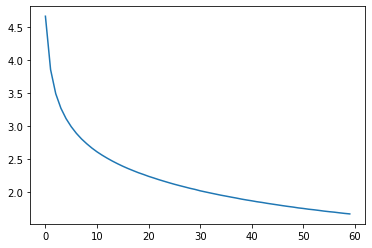

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

誤差はまだ収束していないので、さらにエポック数を重ねることにより結果は改善しそうです。  
今回は文書を自動で生成しましたが、同様にしてRNNを自動作曲などに応用することも可能です。

## 課題
青空文庫の「銀河鉄道の夜」を読み込み、宮沢賢治風の文章を自動生成してみましょう。  
このノートブックと同じフォルダに、以下のファイルがあります。  
gingatetsudono_yoru.txt